Setup steps for notebook- import necessary libraries and mount drive.

In [29]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
import fastai
from fastai.vision import *
import torch
import torchvision.transforms.functional as F

import tarfile, os,pathlib

Copy the preprocessed 250x250 patches from valid.tar to current VM for classification task. There are around 10000 images. Likewise we will be using the masks.tar for labelling the images with buildingpresent and buildingabsent.

In [0]:
!rm -rf /content/valid
!rm -rf /content/masks
!tar -zxvf '/content/valid.tar'
!tar -zxvf '/content/masks.tar'

Create train subset with labels for classification as per fastai. Also, create staging folders for labelling.

In [0]:
!rm -rf '/content/platform_demo'
!mkdir '/content/platform_demo'

!mkdir /content/platform_demo/train

!mkdir /content/platform_demo/train/present
!mkdir /content/platform_demo/train/absent

!rm -rf /content/present
!rm -rf /content/absent
!mkdir /content/present
!mkdir /content/absent

Functions to move the images into staging folder for present and absent classes based on pixel density. If density of white pixel is 0, it belongs to absent classes else present class.

In [0]:
import os,random,pathlib,shutil
img_path = Path('/content/valid')
mask_path = Path('/content/masks')
train_dir = Path('/content/platform_demo/train')

root_dir = Path('/content')

def get_pct(arr):
  tot = np.count_nonzero(arr==0)+np.count_nonzero(arr==1)
  whites = np.count_nonzero(arr==1)
  pop_pct = (whites/tot) * 100
  return pop_pct

def create_datasets(src_dir, dest_dir):
  for file in get_image_files(src_dir):
    mask_file = mask_path/f'{file.name}'
    img = open_image(mask_file)
    pct = get_pct(img.data.numpy())
    if(pct==0):
      shutil.move(img_path/f'{file}',dest_dir/'absent'/f'{file.name}')
    else:
      shutil.move(img_path/f'{file}',dest_dir/'present'/f'{file.name}')
         

Selecting a random set of 1000 images in total for present and absent class, for classification.

In [0]:
create_datasets('/content/valid',root_dir)
pres_path = Path('/content/present')
abs_path = Path('/content/absent')

for i in range(1000):
  val = random.randint(1,2000)
  if(val > 1000):
    file = random.choice(os.listdir('/content/present'))
    shutil.move(pres_path/f'{file}',train_dir/'present'/f'{file}')
  else:
    file = random.choice(os.listdir('/content/absent'))
    shutil.move(abs_path/f'{file}',train_dir/'absent'/f'{file}')
  
  

In [70]:
len(get_image_files('/content/platform_demo/train/present')),len(get_image_files('/content/platform_demo/train/absent'))

(504, 496)

Download the train folder to be used for labelling in platform.ai. 

In [71]:
!tar -zcvf train_demo.tar '/content/platform_demo/train' 

tar: Removing leading `/' from member names
/content/platform_demo/train/
/content/platform_demo/train/present/
/content/platform_demo/train/present/kitsap4_38.tif
/content/platform_demo/train/present/vienna5_288.tif
/content/platform_demo/train/present/austin2_235.tif
/content/platform_demo/train/present/vienna1_101.tif
/content/platform_demo/train/present/chicago5_379.tif
/content/platform_demo/train/present/chicago5_349.tif
/content/platform_demo/train/present/tyrol-w4_174.tif
/content/platform_demo/train/present/tyrol-w4_25.tif
/content/platform_demo/train/present/kitsap5_363.tif
/content/platform_demo/train/present/austin4_323.tif
/content/platform_demo/train/present/kitsap2_228.tif
/content/platform_demo/train/present/vienna2_255.tif
/content/platform_demo/train/present/chicago1_155.tif
/content/platform_demo/train/present/vienna2_109.tif
/content/platform_demo/train/present/chicago3_106.tif
/content/platform_demo/train/present/austin5_148.tif
/content/platform_demo/train/present

Preparing databunch for classification as per fast.ai

In [0]:
tfms = get_transforms(do_flip=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.2,
                      xtra_tfms=[brightness(change=(0.7, 0.9), p=0.75),
                                 contrast(scale=(1.5, 1.9), p=0.75)])

In [0]:
path = Path('/content/platform_demo/train')
src = (ImageList.from_folder(path) #define source of input
      .split_by_rand_pct(0.2)
      .label_from_folder())
data = (src.transform(tfms, size=250)
       .databunch(bs=32))#batch size=16

In [74]:
data

ImageDataBunch;

Train: LabelList (800 items)
x: ImageList
Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250)
y: CategoryList
present,present,present,present,present
Path: /content/platform_demo/train;

Valid: LabelList (200 items)
x: ImageList
Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250)
y: CategoryList
present,present,present,present,absent
Path: /content/platform_demo/train;

Test: None

In [0]:
classes = ['present','absent']

##CNN Learner##

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-03


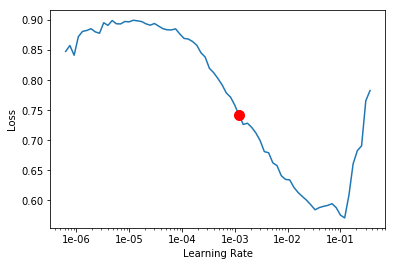

In [77]:
learn.freeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [78]:
lr = 1e-02
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.421111,0.303802,0.920000,00:08
1,0.356324,0.210732,0.910000,00:07
2,0.297534,0.194321,0.910000,00:07
3,0.248788,0.178126,0.925000,00:07
4,0.220905,0.179483,0.925000,00:07


In [0]:
learn.save('inria_250_resnet34_stg1_clss')
!cp '/content/platform_demo/train/models/inria_250_resnet34_stg1_clss.pth' '/content/drive/My Drive/fellowship/'

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06


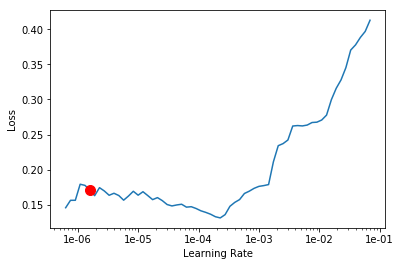

In [80]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [81]:
lr = 1.58E-06
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.165079,0.175796,0.925000,00:08
1,0.177487,0.180729,0.930000,00:08
2,0.172171,0.179455,0.925000,00:08
3,0.171171,0.178558,0.925000,00:08
4,0.173032,0.183303,0.930000,00:08


In [82]:
learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.162787,0.173557,0.920000,00:07
1,0.173046,0.178003,0.925000,00:08
2,0.173960,0.179934,0.935000,00:08


In [83]:
learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.148227,0.176848,0.925000,00:08
1,0.173980,0.178260,0.925000,00:08
2,0.182364,0.175414,0.920000,00:08


In [0]:
learn.save('inria_250_resnet34_stg2_clss')
!cp '/content/platform_demo/train/models/inria_250_resnet34_stg2_clss.pth' '/content/drive/My Drive/fellowship/'
!cp '/content/platform_demo/train/models/tmp.pth' '/content/drive/My Drive/fellowship/'

In [0]:
learn.export()
!cp '/content/platform_demo/train/export.pkl' '/content/drive/My Drive/fellowship/'

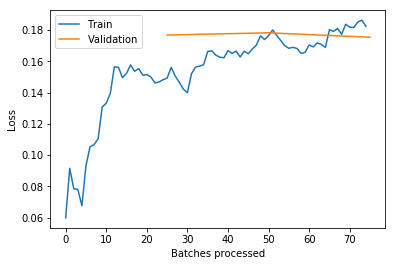

In [86]:
learn.recorder.plot_losses()

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

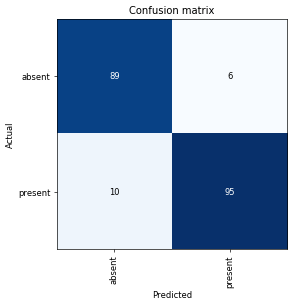

In [88]:
interp.plot_confusion_matrix(figsize=(5, 5), dpi=60)